# POS tagging using modified Viterbi

## Installing libraries

In [1]:
!pip install word2number

## Importing libraries and common utility functions

In [2]:
import nltk
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import math
import re

from nltk.tokenize import word_tokenize

from word2number import w2n

from collections import Counter

from sklearn.model_selection import train_test_split

def get_diff_bet_tagged_cases(tagged_seq, default_seq, comparing_incorrect = True):
    diff_bet_tagged_cases = [[default_seq[i-1],j] for i, j in enumerate(zip(default_seq, tagged_seq)) if j[0]!=j[1]]
    if comparing_incorrect:
        print('Total incorrect tag cases : {}'.format(len(diff_bet_tagged_cases)))
    else:
        print('Total different tag cases : {}'.format(len(diff_bet_tagged_cases)))
    return diff_bet_tagged_cases

def get_most_common_diff_tags(diff_bet_tagged_cases, top_n_rows = 10, comparing_incorrect = True):
    diff_bet_tag_seq_list = [(previous[1], current[0][1], current[1][1]) for previous, current in diff_bet_tagged_cases]
    most_common_tag_seq_list = list(Counter(diff_bet_tag_seq_list).most_common(top_n_rows))
    if comparing_incorrect:
        print('Most common incorrect tagged sequence: \n')
        print('Previous, Correct, Incorrect:')
    else:
        print('Most common different tagged sequence: \n')
        print('Previous, Default, Predicted:')
    
    display(most_common_tag_seq_list)
    return most_common_tag_seq_list

def get_most_common_words_for_diff_bet_tag(diff_bet_tagged_cases, tag_seq, comparing_incorrect = True):
    most_common_diff_words = [(previous, current[0], current[1]) for previous, current in diff_bet_tagged_cases \
                                   if previous[1] == tag_seq[0] and current[0][1] == tag_seq[1] 
                                    and current[1][1] == tag_seq[2]]
    if comparing_incorrect:
        print('Most common incorrect tag words:')
        print('Previous, Correct, Incorrect:')
    else:
        print('Most common different tag words:')
        print('Previous, Default, Predicted:')
    display(most_common_diff_words)
    return most_common_diff_words
    
    
def check_accuracy(tagged_seq, run_base):
    check = [i for i, j in zip(tagged_seq, run_base) if i == j] 
    accuracy = len(check)/len(run_base)
    print('Accuracy : {}'.format(accuracy))
    
def frequency_distribution_for_word_tags(incorrect_word_tags):
    total_tags_per_words = {tup[1][0]:[] for tup in incorrect_word_tags}

    for i, tup in enumerate(validation_tagged_words):
        if tup[0] in total_tags_per_words:
            total_tags_per_words[tup[0]].append(tup[1])

    num_rows = math.ceil(len(total_tags_per_words) / 3)  if len(total_tags_per_words) > 3 else len(total_tags_per_words)
    col_rows = 3 if len(total_tags_per_words) > 3 else len(total_tags_per_words)

    plt.figure(figsize=(10*col_rows, 5*num_rows))
    for i, word in enumerate(total_tags_per_words):
        plt.subplot(num_rows, col_rows, i+1)
        ax = sns.countplot(total_tags_per_words[word])
        ax.set_title('Tags freq distribution - {}'.format(word))
        
    plt.show()
    
def tags_distribution_for_pattern(pattern, tag_seq):
    words_matching_pattern = [pair for pair in tag_seq if re.search(pattern, pair[0])]
    total_words_matching_pattern = len(words_matching_pattern)
    print('Total words matching pattern : {}'.format(total_words_matching_pattern))

    words_matching_pattern_tags = [pair[1] for pair in words_matching_pattern]
    words_matching_pattern_most_common_tags = Counter(words_matching_pattern_tags).most_common(10)
    print('\nMost common tags for words matching pattern :')
    print(words_matching_pattern_most_common_tags)
    
    print('\nTag Ratios : ')
    print('Tag , Ratio')
    for most_common_tag in words_matching_pattern_most_common_tags:
        tag = most_common_tag[0]
        words_matching_pattern_with_tag = [pair for pair in words_matching_pattern if pair[1] == tag]
        total_words_matching_pattern_with_tag = len(words_matching_pattern_with_tag)
        print('{} , {} '.format(tag, round((total_words_matching_pattern_with_tag/total_words_matching_pattern)*100,2)))
        
    return words_matching_pattern
        
def get_incorrect_tagged_words(incorrect_tagged_cases):
    return [current[0] for previous, current in incorrect_tagged_cases]

def find_metrics_for_updated_viterbi(updated_incorrect_tagged_cases, difference_with_default_tagged_cases):
    incorrect_tagged_words = [(previous[0], current[0][0]) for previous, current in updated_incorrect_tagged_cases]
    corrected_tagged_cases = [(previous, current[0], current[1]) for previous, current in \
                              difference_with_default_tagged_cases 
                         if (previous[0], current[0][0]) not in incorrect_tagged_words]
    incorrect_tagged_cases = [(previous, current[0], current[1]) for previous, current in \
                              difference_with_default_tagged_cases 
                         if (previous[0], current[0][0]) in incorrect_tagged_words]
    print('Total updated correct tag cases : {}'.format(len(corrected_tagged_cases)))
    print('Previous, Default, Correct')
    display(corrected_tagged_cases)
    
    print('Total updated incorrect tag cases : {}'.format(len(incorrect_tagged_cases)))
    print('Previous, Default, Incorrect')
    display(incorrect_tagged_cases)

## Downloading nltk data

In [3]:
nltk.download('treebank')
nltk.download('universal_tagset')

[nltk_data] Downloading package treebank to
[nltk_data]     C:\Users\Apoorv\AppData\Roaming\nltk_data...
[nltk_data]   Package treebank is already up-to-date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     C:\Users\Apoorv\AppData\Roaming\nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


True

## Data Preparation

### Reading nltk data

In [4]:
# reading the Treebank tagged sentences
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

nltk_data_sorted = sorted(nltk_data)

print('Total data : {}'.format(len(nltk_data_sorted)))

Total data : 3914


### Reading test data

In [5]:
test_file = open("Test_sentences.txt", "rb")
test_set = [word_tokenize(sent) for sent in test_file.read().decode("utf-8").splitlines() if len(sent) > 0]
print('Total test set : {}'.format(len(test_set)))
print('\nTest set samples : ')
print(test_set[:2])

Total test set : 11

Test set samples : 
[['Android', 'is', 'a', 'mobile', 'operating', 'system', 'developed', 'by', 'Google', '.'], ['Android', 'has', 'been', 'the', 'best-selling', 'OS', 'worldwide', 'on', 'smartphones', 'since', '2011', 'and', 'on', 'tablets', 'since', '2013', '.']]


### Splitting training and validation data set

In [6]:
train_set, validation_set = train_test_split(nltk_data_sorted, test_size = 0.05, random_state = 100)

print('Total train set : {}'.format(len(train_set)))
print('\nTrain set samples : ')
print(train_set[:2])

print('\nTotal validation set : {}'.format(len(validation_set)))
print('\nValidation set samples : ')
print(validation_set[:2])

Total train set : 3718

Train set samples : 
[[('Late', 'ADV'), ('that', 'DET'), ('afternoon', 'NOUN'), ('the', 'DET'), ('S&P', 'NOUN'), ('500', 'NUM'), ('stock-index', 'ADJ'), ('futures', 'NOUN'), ('contract', 'NOUN'), ('fell', 'VERB'), ('a', 'DET'), ('total', 'NOUN'), ('of', 'ADP'), ('30', 'NUM'), ('index', 'NOUN'), ('points', 'NOUN'), (',', '.'), ('*-1', 'X'), ('hitting', 'VERB'), ('a', 'DET'), ('Merc', 'NOUN'), ('circuit', 'NOUN'), ('breaker', 'NOUN'), ('limit', 'NOUN'), ('that', 'DET'), ('*T*-210', 'X'), ('remained', 'VERB'), ('in', 'ADP'), ('effect', 'NOUN'), ('for', 'ADP'), ('the', 'DET'), ('rest', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('trading', 'NOUN'), ('session', 'NOUN'), ('.', '.')], [('It', 'PRON'), ('ended', 'VERB'), ('the', 'DET'), ('day', 'NOUN'), ('up', 'ADV'), ('80', 'NUM'), ('yen', 'NOUN'), ('-LRB-', '.'), ('56', 'NUM'), ('cents', 'NOUN'), ('-RRB-', '.'), ('to', 'PRT'), ('1,880', 'NUM'), ('yen', 'NOUN'), ('-LRB-', '.'), ('$', '.'), ('13.15', 'NUM'), ('*U*', 'X'), 

### Training Data

#### Preparing data

In [7]:
train_tagged_words = [tup for sent in train_set for tup in sent]
print('Total train tagged words : {}'.format(len(train_tagged_words)))

Total train tagged words : 95581


#### Exploring data

In [8]:
training_tokens = [pair[0] for pair in train_tagged_words]
print('Total training tokens : {}'.format(len(training_tokens)))

training_vocab = list(set(training_tokens))
print('\nTotal training vocabulary : {}'.format(len(training_vocab)))

print('\nMost common training tokens : ')
print(Counter(training_tokens).most_common(10))

training_tags = Counter(pair[1] for pair in train_tagged_words).most_common(20)
print('\nTotal training tags : {}'.format(len(training_tags)))
print('\nMost common training tags :')
print(training_tags)

Total training tokens : 95581

Total training vocabulary : 12100

Most common training tokens : 
[(',', 4649), ('the', 3855), ('.', 3633), ('of', 2204), ('to', 2052), ('a', 1776), ('in', 1490), ('and', 1443), ('*-1', 1064), ('0', 1029)]

Total training tags : 12

Most common training tags :
[('NOUN', 27441), ('VERB', 12836), ('.', 11137), ('ADP', 9346), ('DET', 8284), ('X', 6251), ('ADJ', 6093), ('NUM', 3412), ('PRT', 3059), ('ADV', 3004), ('PRON', 2557), ('CONJ', 2161)]


### Validation Data

#### Preparing data

In [9]:
validation_tagged_words = [tup for sent in validation_set for tup in sent]
validation_words = [tup[0] for tup in validation_tagged_words]
print('Total validation tagged words : {}'.format(len(validation_tagged_words)))

Total validation tagged words : 5095


#### Exploring data

In [10]:
print('Total validation tokens : {}'.format(len(validation_words)))

validation_vocab = list(set(validation_words))
print('\nTotal validation vocabulary : {}'.format(len(validation_vocab)))

print('\nMost common validation tokens : ')
print(Counter(validation_words).most_common(10))

validation_tags = Counter(pair[1] for pair in validation_tagged_words).most_common(20)
print('\nTotal validation tags : {}'.format(len(validation_tags)))
print('\nMost common validation tags :')
print(validation_tags)

Total validation tokens : 5095

Total validation vocabulary : 1906

Most common validation tokens : 
[(',', 236), ('.', 195), ('the', 190), ('of', 115), ('to', 112), ('a', 102), ('in', 82), ('0', 70), ('and', 68), ('*', 64)]

Total validation tags : 12

Most common validation tags :
[('NOUN', 1426), ('VERB', 728), ('.', 578), ('ADP', 511), ('DET', 441), ('X', 362), ('ADJ', 304), ('PRON', 180), ('ADV', 167), ('PRT', 160), ('NUM', 134), ('CONJ', 104)]


### Test Data

#### Preparing data

In [11]:
test_words = [word for sent in test_set for word in sent]
print('Total test words : {}'.format(len(test_words)))

Total test words : 181


##### Evaluating POS tags for test sentences using online tool to approximate accuracy:

For correct approximation, following steps have been formed:

1) Get results of test sentence from spacy online tool: http://textanalysisonline.com/spacy-pos-tagging

2) Replaced PUNCT with . and PART with PRT</b> to match nltk universal tags in results

3) Replaced best-selling|ADV -|. selling|VERB from result to with best-selling|ADJ to match test parsed tokens based on other POS tagging tool : https://parts-of-speech.info/

In [12]:
test_spacy_results = [
"Android|NOUN is|VERB a|DET mobile|ADJ operating|VERB system|NOUN developed|VERB by|ADP Google|NOUN .|.",

"Android|NOUN has|VERB been|VERB the|DET best-selling|ADJ OS|NOUN worldwide|ADV on|ADP smartphones|NOUN since|ADP 2011|NUM and|CONJ on|ADP tablets|NOUN since|ADP 2013|NUM .|.",

"Google|NOUN and|CONJ Twitter|NOUN made|VERB a|DET deal|NOUN in|ADP 2015|NUM that|ADJ gave|VERB Google|NOUN access|NOUN to|ADP Twitter|NOUN 's|PRT firehose|NOUN .|.",

"Twitter|NOUN is|VERB an|DET online|ADJ news|NOUN and|CONJ social|ADJ networking|NOUN service|NOUN on|ADP which|ADJ users|NOUN post|VERB and|CONJ interact|VERB with|ADP messages|NOUN known|VERB as|ADP tweets|NOUN .|.",

"Before|ADP entering|VERB politics|NOUN ,|. Donald|NOUN Trump|NOUN was|VERB a|DET domineering|ADJ businessman|NOUN and|CONJ a|DET television|NOUN personality|NOUN .|.",

"The|DET 2018|NUM FIFA|NOUN World|NOUN Cup|NOUN is|VERB the|DET 21st|ADJ FIFA|NOUN World|NOUN Cup|NOUN ,|. an|DET international|ADJ football|NOUN tournament|NOUN contested|VERB once|ADV every|DET four|NUM years|NOUN .|.", 

"This|DET is|VERB the|DET first|ADJ World|NOUN Cup|NOUN to|PRT be|VERB held|VERB in|ADP Eastern|NOUN Europe|NOUN and|CONJ the|DET 11th|ADJ time|NOUN that|ADJ it|NOUN has|VERB been|VERB held|VERB in|ADP Europe|NOUN .|.",

"Show|NOUN me|NOUN the|DET cheapest|ADJ round|NOUN trips|NOUN from|ADP Dallas|NOUN to|ADP Atlanta|NOUN",

"I|NOUN would|VERB like|VERB to|PRT see|VERB flights|NOUN from|ADP Denver|NOUN to|ADP Philadelphia|NOUN .|.",

"Show|NOUN me|NOUN the|DET price|NOUN of|ADP the|DET flights|NOUN leaving|VERB Atlanta|NOUN at|ADP about|ADP 3|NUM in|ADP the|DET afternoon|NOUN and|CONJ arriving|VERB in|ADP San|NOUN Francisco|NOUN .|.",

"NASA|NOUN invited|VERB social|ADJ media|NOUN users|NOUN to|PRT experience|VERB the|DET launch|NOUN of|ADP ICESAT-2|NOUN Satellite|NOUN .|."
]

##### Preparing test tagged data

In [13]:
test_tagged_sents = [sent.split(" ") for sent in test_spacy_results]

test_tagged_words = [tuple(tagged_word.split("|")) for tagged_sent in test_tagged_sents for tagged_word in tagged_sent]

print('Total test tagged words : {}'.format(len(test_tagged_words)))
print('Extra tokens present in tagged results : {}'
      .format([pair for pair in test_tagged_words if pair[0] not in test_words]))

Total test tagged words : 181
Extra tokens present in tagged results : []


#### Exploring data

In [14]:
print('Total test tokens : {}'.format(len(test_words)))

test_vocab = list(set(test_words))
print('\nTotal test vocabulary : {}'.format(len(test_vocab)))

print('\nMost common test tokens : ')
print(Counter(test_words).most_common(10))

test_tags = Counter(pair[1] for pair in test_tagged_words).most_common(20)

print('\nTotal test tags : {}'.format(len(test_tags)))
print('\nMost common test tags :')
print(test_tags)

Total test tokens : 181

Total test vocabulary : 115

Most common test tokens : 
[('.', 10), ('the', 9), ('and', 7), ('to', 6), ('in', 5), ('is', 4), ('a', 4), ('Google', 3), ('on', 3), ('Twitter', 3)]

Total test tags : 10

Most common test tags :
[('NOUN', 67), ('VERB', 28), ('ADP', 23), ('DET', 18), ('ADJ', 14), ('.', 12), ('CONJ', 7), ('NUM', 6), ('PRT', 4), ('ADV', 2)]


## Build the Vanilla Viterbi based POS tagger

### Implementing Vanilla Viterbi

In [15]:
class VanillaViterbiTagger(nltk.TaggerI):
    def __init__(self, train_bag):
        self.train_data = train_bag
        self.vocab = set([pair[0] for pair in self.train_data])
        self.tags = sorted(set([pair[1] for pair in self.train_data]))
        self.tags_matrix = np.zeros((len(self.tags), len(self.tags)), dtype = 'float32')
        
        for i, t1 in enumerate(self.tags):
            for j, t2 in enumerate(self.tags):
                self.tags_matrix[i,j] = self.get_transition_probability(t2, t1)
        
        self.tags_df = pd.DataFrame(self.tags_matrix, columns = self.tags, index=self.tags)
        
    def get_emission_probability(self, word, tag):
        '''Returns Emission Probabilities'''
        tag_list = [pair for pair in self.train_data if tag == pair[1]]
        count_tag = len(tag_list)
        w_given_tag_list = [pair[0] for pair in tag_list if word == pair[0]]
        count_w_given_tag = len(w_given_tag_list)
    
        return (count_w_given_tag / count_tag)
    
    def get_transition_probability(self, t2, t1):
        '''Returns Transition Probabilties''' 
        tags = [pair[1] for pair in self.train_data]
        count_t1 = len([tag for tag in tags if tag == t1])
        count_t2_given_t1 = 0
        for index in range(len(tags) -1):
            if tags[index] == t1 and tags[index + 1] == t2:
                count_t2_given_t1 += 1
        return (count_t2_given_t1 / count_t1) 

    def tag(self, words):
        state = []
        for index, word in enumerate(words):
            p = []
            for tag in self.tags:
                if index == 0:
                    transition_p = self.tags_df.loc['.', tag]
                else:
                    transition_p = self.tags_df.loc[state[-1], tag]

                emission_prob = self.get_emission_probability(word, tag)
                state_prob = emission_prob * transition_p
                p.append(state_prob)
                
            pmax = max(p)
            state_max = self.tags[p.index(pmax)]
            state.append(state_max)

        return list(zip(words, state))        

### Instantiating Vanilla Viterbi

In [16]:
vanilla_viterbi = VanillaViterbiTagger(train_tagged_words)

### Validating Vanilla Viterbi implementation

#### Validating Emission Probabilities implementation

In [17]:
print(format(vanilla_viterbi.get_emission_probability('medium-sized', 'ADJ'), 'f'))
print(format(vanilla_viterbi.get_emission_probability('altered', 'VERB'), 'f'))

0.000492
0.000078


#### Validating Transition Probabilities implementation

In [18]:
print(format(vanilla_viterbi.get_transition_probability('NOUN', 'ADJ'), 'f'))
print(format(vanilla_viterbi.get_transition_probability('NOUN', 'DET'), 'f'))
print(format(vanilla_viterbi.get_transition_probability('NOUN', 'VERB'), 'f'))
print(format(vanilla_viterbi.get_transition_probability('DET', '.'), 'f'))
print(format(vanilla_viterbi.get_transition_probability('NOUN', '.'), 'f'))

0.700640
0.637132
0.110081
0.173027
0.222502


#### Exploring Transition Probabilities

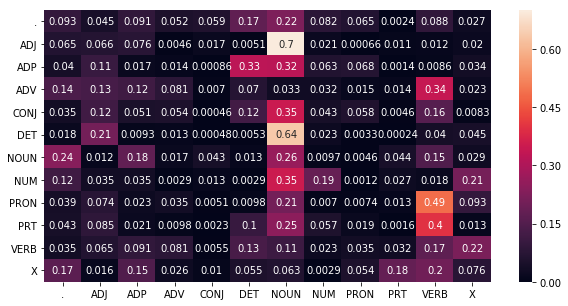

In [19]:
plt.figure(figsize = (10,5))
sns.heatmap(vanilla_viterbi.tags_df,annot = True)
plt.show()

### POS Tagging Validation Data Set with Vanilla Viterbi

In [20]:
default_predicted_validation_tagged_words = vanilla_viterbi.tag(validation_words)

### Checking accuracy for validation data set with Vanilla Viterbi

In [21]:
check_accuracy(default_predicted_validation_tagged_words, validation_tagged_words)

Accuracy : 0.9089303238469087


### Most common incorrect tagged cases with Vanilla Viterbi

In [22]:
default_incorrect_validation_tagged_cases = get_diff_bet_tagged_cases(default_predicted_validation_tagged_words, 
                                                            validation_tagged_words)

default_most_common_validation_incorrect_tags = get_most_common_diff_tags(default_incorrect_validation_tagged_cases)

Total incorrect tag cases : 464
Most common incorrect tagged sequence: 

Previous, Correct, Incorrect:


[(('NOUN', 'NOUN', '.'), 46),
 (('DET', 'NOUN', '.'), 25),
 (('ADJ', 'NOUN', '.'), 24),
 (('DET', 'ADJ', '.'), 22),
 (('.', 'NOUN', '.'), 17),
 (('ADP', 'NOUN', '.'), 14),
 (('NOUN', 'DET', 'ADP'), 13),
 (('X', 'VERB', '.'), 12),
 (('.', 'NUM', '.'), 12),
 (('VERB', 'ADJ', 'ADV'), 11)]

### POS Tagging Test Data Set with Vanilla Viterbi

In [23]:
default_predicted_test_tagged_words = vanilla_viterbi.tag(test_words)
print(default_predicted_test_tagged_words)

[('Android', '.'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', '.'), ('.', '.'), ('Android', '.'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', '.'), ('worldwide', '.'), ('on', 'ADP'), ('smartphones', '.'), ('since', 'ADP'), ('2011', '.'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', '.'), ('.', '.'), ('Google', '.'), ('and', 'CONJ'), ('Twitter', '.'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', '.'), ('that', 'DET'), ('gave', 'VERB'), ('Google', '.'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', '.'), ("'s", 'VERB'), ('firehose', '.'), ('.', '.'), ('Twitter', '.'), ('is', 'VERB'), ('an', 'DET'), ('online', '.'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on', 'ADP'), ('which', 'DET'), ('users', 'NOUN'), ('post', 'NOUN'), ('and', 

## Solve the problem of unknown words

### Modifying Vanilla Viterbi with 1st technique

<b> If the word is not in training vocabulary then emission probability for that word becomes 0, which in turn makes the state probability as 0. Thus, effectively selecting first tag present in the tag list. This approach checks if the word is present in vocabulary and only rely on transition probability in case the word is not present in vocabulary. </b>

#### Implementing 1st Modified Viterbi

In [24]:
class UpdatedViterbiTagger1(VanillaViterbiTagger):
    
    def __init__(self, train_bag):
        super().__init__(train_bag)
       
    def tag(self, words):
        state = []
        for index, word in enumerate(words):
            p = []
            for tag in self.tags:
                if index == 0:
                    transition_p = self.tags_df.loc['.', tag]
                else:
                    transition_p = self.tags_df.loc[state[-1], tag]

                if word in self.vocab:
                    emission_prob = self.get_emission_probability(word, tag)
                    state_prob = emission_prob * transition_p
                else:
                    state_prob = transition_p
                    
                p.append(state_prob)

            pmax = max(p)
            state_max = self.tags[p.index(pmax)]  
            state.append(state_max)

        return list(zip(words, state))        

#### Instantiating 1st Modified Viterbi

In [25]:
updated_viterbi_1 = UpdatedViterbiTagger1(train_tagged_words)

#### POS Tagging Validation Data Set with 1st Modified Viterbi

In [26]:
updated_predicted_validation_tagged_words_1 = updated_viterbi_1.tag(validation_words)

#### Checking accuracy for validation data set with 1st Modified Viterbi

In [27]:
check_accuracy(updated_predicted_validation_tagged_words_1, validation_tagged_words)

Accuracy : 0.9377821393523061


#### Most common incorrect tagged cases with 1st Modified Viterbi

In [28]:
updated_incorrect_validation_tagged_cases_1 = get_diff_bet_tagged_cases(updated_predicted_validation_tagged_words_1, 
                                                            validation_tagged_words)
updated_most_common_validation_incorrect_tags_1 = get_most_common_diff_tags(updated_incorrect_validation_tagged_cases_1)

Total incorrect tag cases : 317
Most common incorrect tagged sequence: 

Previous, Correct, Incorrect:


[(('DET', 'ADJ', 'NOUN'), 22),
 (('NOUN', 'VERB', 'NOUN'), 18),
 (('ADP', 'NOUN', 'DET'), 14),
 (('NOUN', 'DET', 'ADP'), 13),
 (('.', 'NUM', 'NOUN'), 12),
 (('VERB', 'ADJ', 'ADV'), 11),
 (('VERB', 'VERB', 'X'), 11),
 (('PRON', 'NOUN', 'VERB'), 9),
 (('DET', 'NOUN', 'ADJ'), 9),
 (('ADP', 'NUM', 'DET'), 9)]

#### POS Tagging Test Data Set with 1st Modified Viterbi

In [29]:
updated_predicted_test_tagged_words_1 = updated_viterbi_1.tag(test_words)
print(updated_predicted_test_tagged_words_1)

[('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'DET'), ('.', '.'), ('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'DET'), ('since', 'ADP'), ('2011', 'DET'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'DET'), ('.', '.'), ('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'DET'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'X'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'VERB'), ("'s", 'PRT'), ('firehose', 'VERB'), ('.', '.'), ('Twitter', 'NOUN'), ('is', 'VERB'), ('an', 'DET'), ('online', 'NOUN'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on', 'ADP'), ('which', 'DET'), ('user

### Modifying Vanilla Viterbi with 2nd technique

#### Exploring incorrect tagged cases of Vanilla Viterbi for patterns

In [30]:
default_incorrect_validation_tagged_words = get_incorrect_tagged_words(default_incorrect_validation_tagged_cases)

default_most_common_validation_incorrect_tags

[(('NOUN', 'NOUN', '.'), 46),
 (('DET', 'NOUN', '.'), 25),
 (('ADJ', 'NOUN', '.'), 24),
 (('DET', 'ADJ', '.'), 22),
 (('.', 'NOUN', '.'), 17),
 (('ADP', 'NOUN', '.'), 14),
 (('NOUN', 'DET', 'ADP'), 13),
 (('X', 'VERB', '.'), 12),
 (('.', 'NUM', '.'), 12),
 (('VERB', 'ADJ', 'ADV'), 11)]

<b>'.' is the first tag in the tag list. Any unknown word will have 0 emission probability, thus 0 state probability. This leads to the assignment of the first tag in the tag list to unknown words</b>

<b>First, starting with patterns which are known words but incorrectly tagged</b>

##### Exploring 1st pattern 

###### Most Common Words

In [31]:
words_for_first_incorrect_tag = get_most_common_words_for_diff_bet_tag(
    default_incorrect_validation_tagged_cases, ('NOUN', 'DET', 'ADP'))

Most common incorrect tag words:
Previous, Correct, Incorrect:


[(('creation', 'NOUN'), ('that', 'DET'), ('that', 'ADP')),
 (('questions', 'NOUN'), ('that', 'DET'), ('that', 'ADP')),
 (('Corp.', 'NOUN'), ('that', 'DET'), ('that', 'ADP')),
 (('trading', 'NOUN'), ('that', 'DET'), ('that', 'ADP')),
 (('ad', 'NOUN'), ('that', 'DET'), ('that', 'ADP')),
 (('club', 'NOUN'), ('that', 'DET'), ('that', 'ADP')),
 (('shares', 'NOUN'), ('that', 'DET'), ('that', 'ADP')),
 (('job', 'NOUN'), ('that', 'DET'), ('that', 'ADP')),
 (('legislation', 'NOUN'), ('that', 'DET'), ('that', 'ADP')),
 (('research', 'NOUN'), ('that', 'DET'), ('that', 'ADP')),
 (('plan', 'NOUN'), ('that', 'DET'), ('that', 'ADP')),
 (('stocks', 'NOUN'), ('that', 'DET'), ('that', 'ADP')),
 (('bill', 'NOUN'), ('that', 'DET'), ('that', 'ADP'))]

##### Tag frequency distribution for most common words

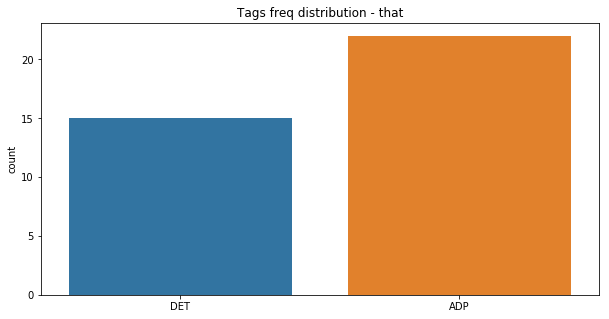

In [32]:
frequency_distribution_for_word_tags(words_for_first_incorrect_tag)

<b>Based on above evidence, there is no clear pattern emerging for rule-based tagging</b>

##### Exploring 2nd pattern 

###### Most Common Words

In [33]:
words_for_second_incorrect_tag = get_most_common_words_for_diff_bet_tag(
    default_incorrect_validation_tagged_cases, ('VERB', 'ADJ', 'ADV'))

Most common incorrect tag words:
Previous, Correct, Incorrect:


[(('fired', 'VERB'), ('more', 'ADJ'), ('more', 'ADV')),
 (('is', 'VERB'), ('less', 'ADJ'), ('less', 'ADV')),
 (('hold', 'VERB'), ('back', 'ADJ'), ('back', 'ADV')),
 (('sold', 'VERB'), ('more', 'ADJ'), ('more', 'ADV')),
 (('get', 'VERB'), ('enough', 'ADJ'), ('enough', 'ADV')),
 (('trade', 'VERB'), ('more', 'ADJ'), ('more', 'ADV')),
 (('fall', 'VERB'), ('further', 'ADJ'), ('further', 'ADV')),
 (('spent', 'VERB'), ('much', 'ADJ'), ('much', 'ADV')),
 (('buy', 'VERB'), ('more', 'ADJ'), ('more', 'ADV')),
 (('be', 'VERB'), ('more', 'ADJ'), ('more', 'ADV')),
 (('create', 'VERB'), ('more', 'ADJ'), ('more', 'ADV'))]

##### Tag frequency distribution for most common words

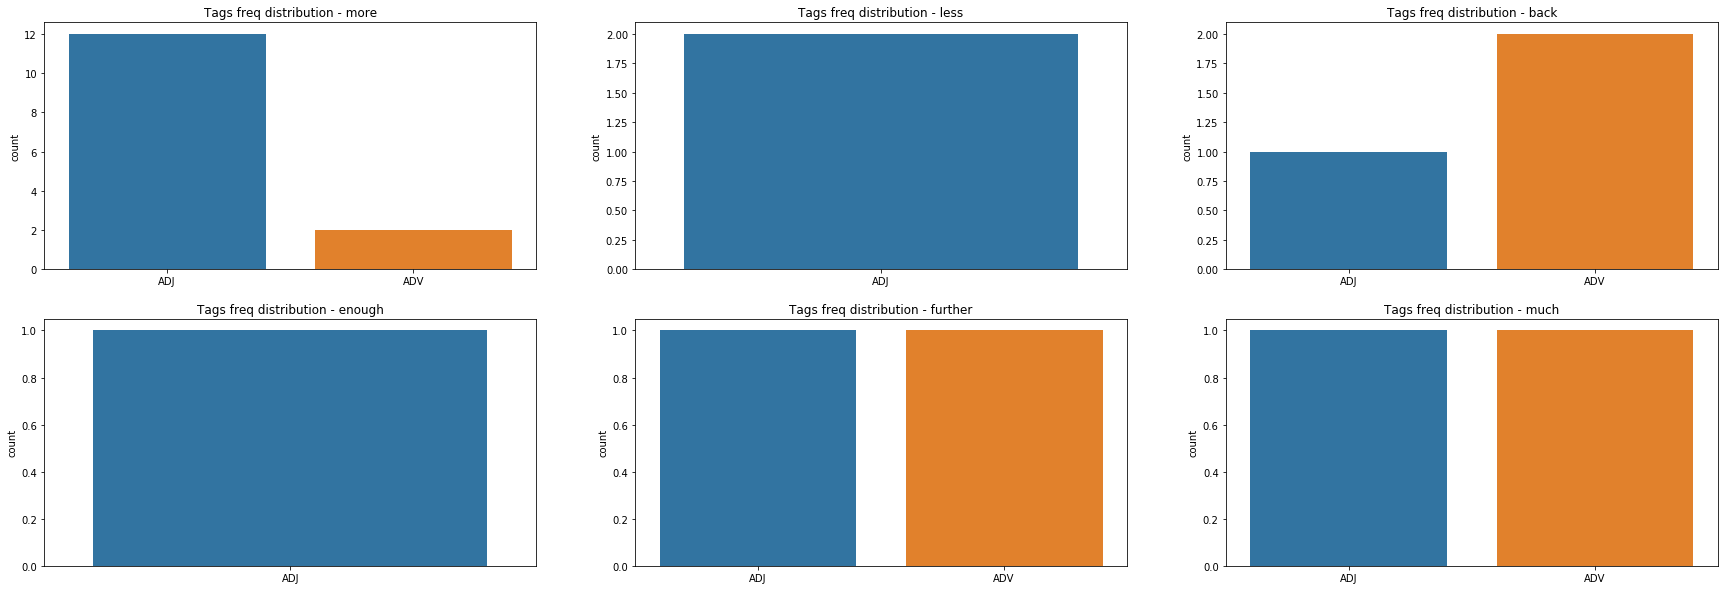

In [34]:
frequency_distribution_for_word_tags(words_for_second_incorrect_tag)

<b>Based on above evidence, there is no clear pattern emerging for rule-based tagging</b>

<b>Second, exploring patterns for unknown words which are incorrectly tagged</b>

##### Exploring 3rd pattern 

###### Most Common Words

In [35]:
words_for_third_incorrect_tag = get_most_common_words_for_diff_bet_tag(
    default_incorrect_validation_tagged_cases, ('DET', 'ADJ', '.'))

Most common incorrect tag words:
Previous, Correct, Incorrect:


[(('a', 'DET'), ('seasoned', 'ADJ'), ('seasoned', '.')),
 (('an', 'DET'), ('eight-count', 'ADJ'), ('eight-count', '.')),
 (('the', 'DET'), ('absolute', 'ADJ'), ('absolute', '.')),
 (('the', 'DET'), ('scholarly', 'ADJ'), ('scholarly', '.')),
 (('the', 'DET'), ('grim', 'ADJ'), ('grim', '.')),
 (('The', 'DET'), ('Nicaraguan', 'ADJ'), ('Nicaraguan', '.')),
 (('the', 'DET'), ('U.S.-backed', 'ADJ'), ('U.S.-backed', '.')),
 (('a', 'DET'), ('19-month-old', 'ADJ'), ('19-month-old', '.')),
 (('The', 'DET'), ('Senate-House', 'ADJ'), ('Senate-House', '.')),
 (('a', 'DET'), ('lighter', 'ADJ'), ('lighter', '.')),
 (('an', 'DET'), ('affordable', 'ADJ'), ('affordable', '.')),
 (('another', 'DET'), ('drag-down', 'ADJ'), ('drag-down', '.')),
 (('a', 'DET'), ('post-hearing', 'ADJ'), ('post-hearing', '.')),
 (('a', 'DET'), ('self-perpetuating', 'ADJ'), ('self-perpetuating', '.')),
 (('these', 'DET'), ('one-country', 'ADJ'), ('one-country', '.')),
 (('a', 'DET'), ('sharper', 'ADJ'), ('sharper', '.')),
 (('

##### Tag frequency distribution for most common words

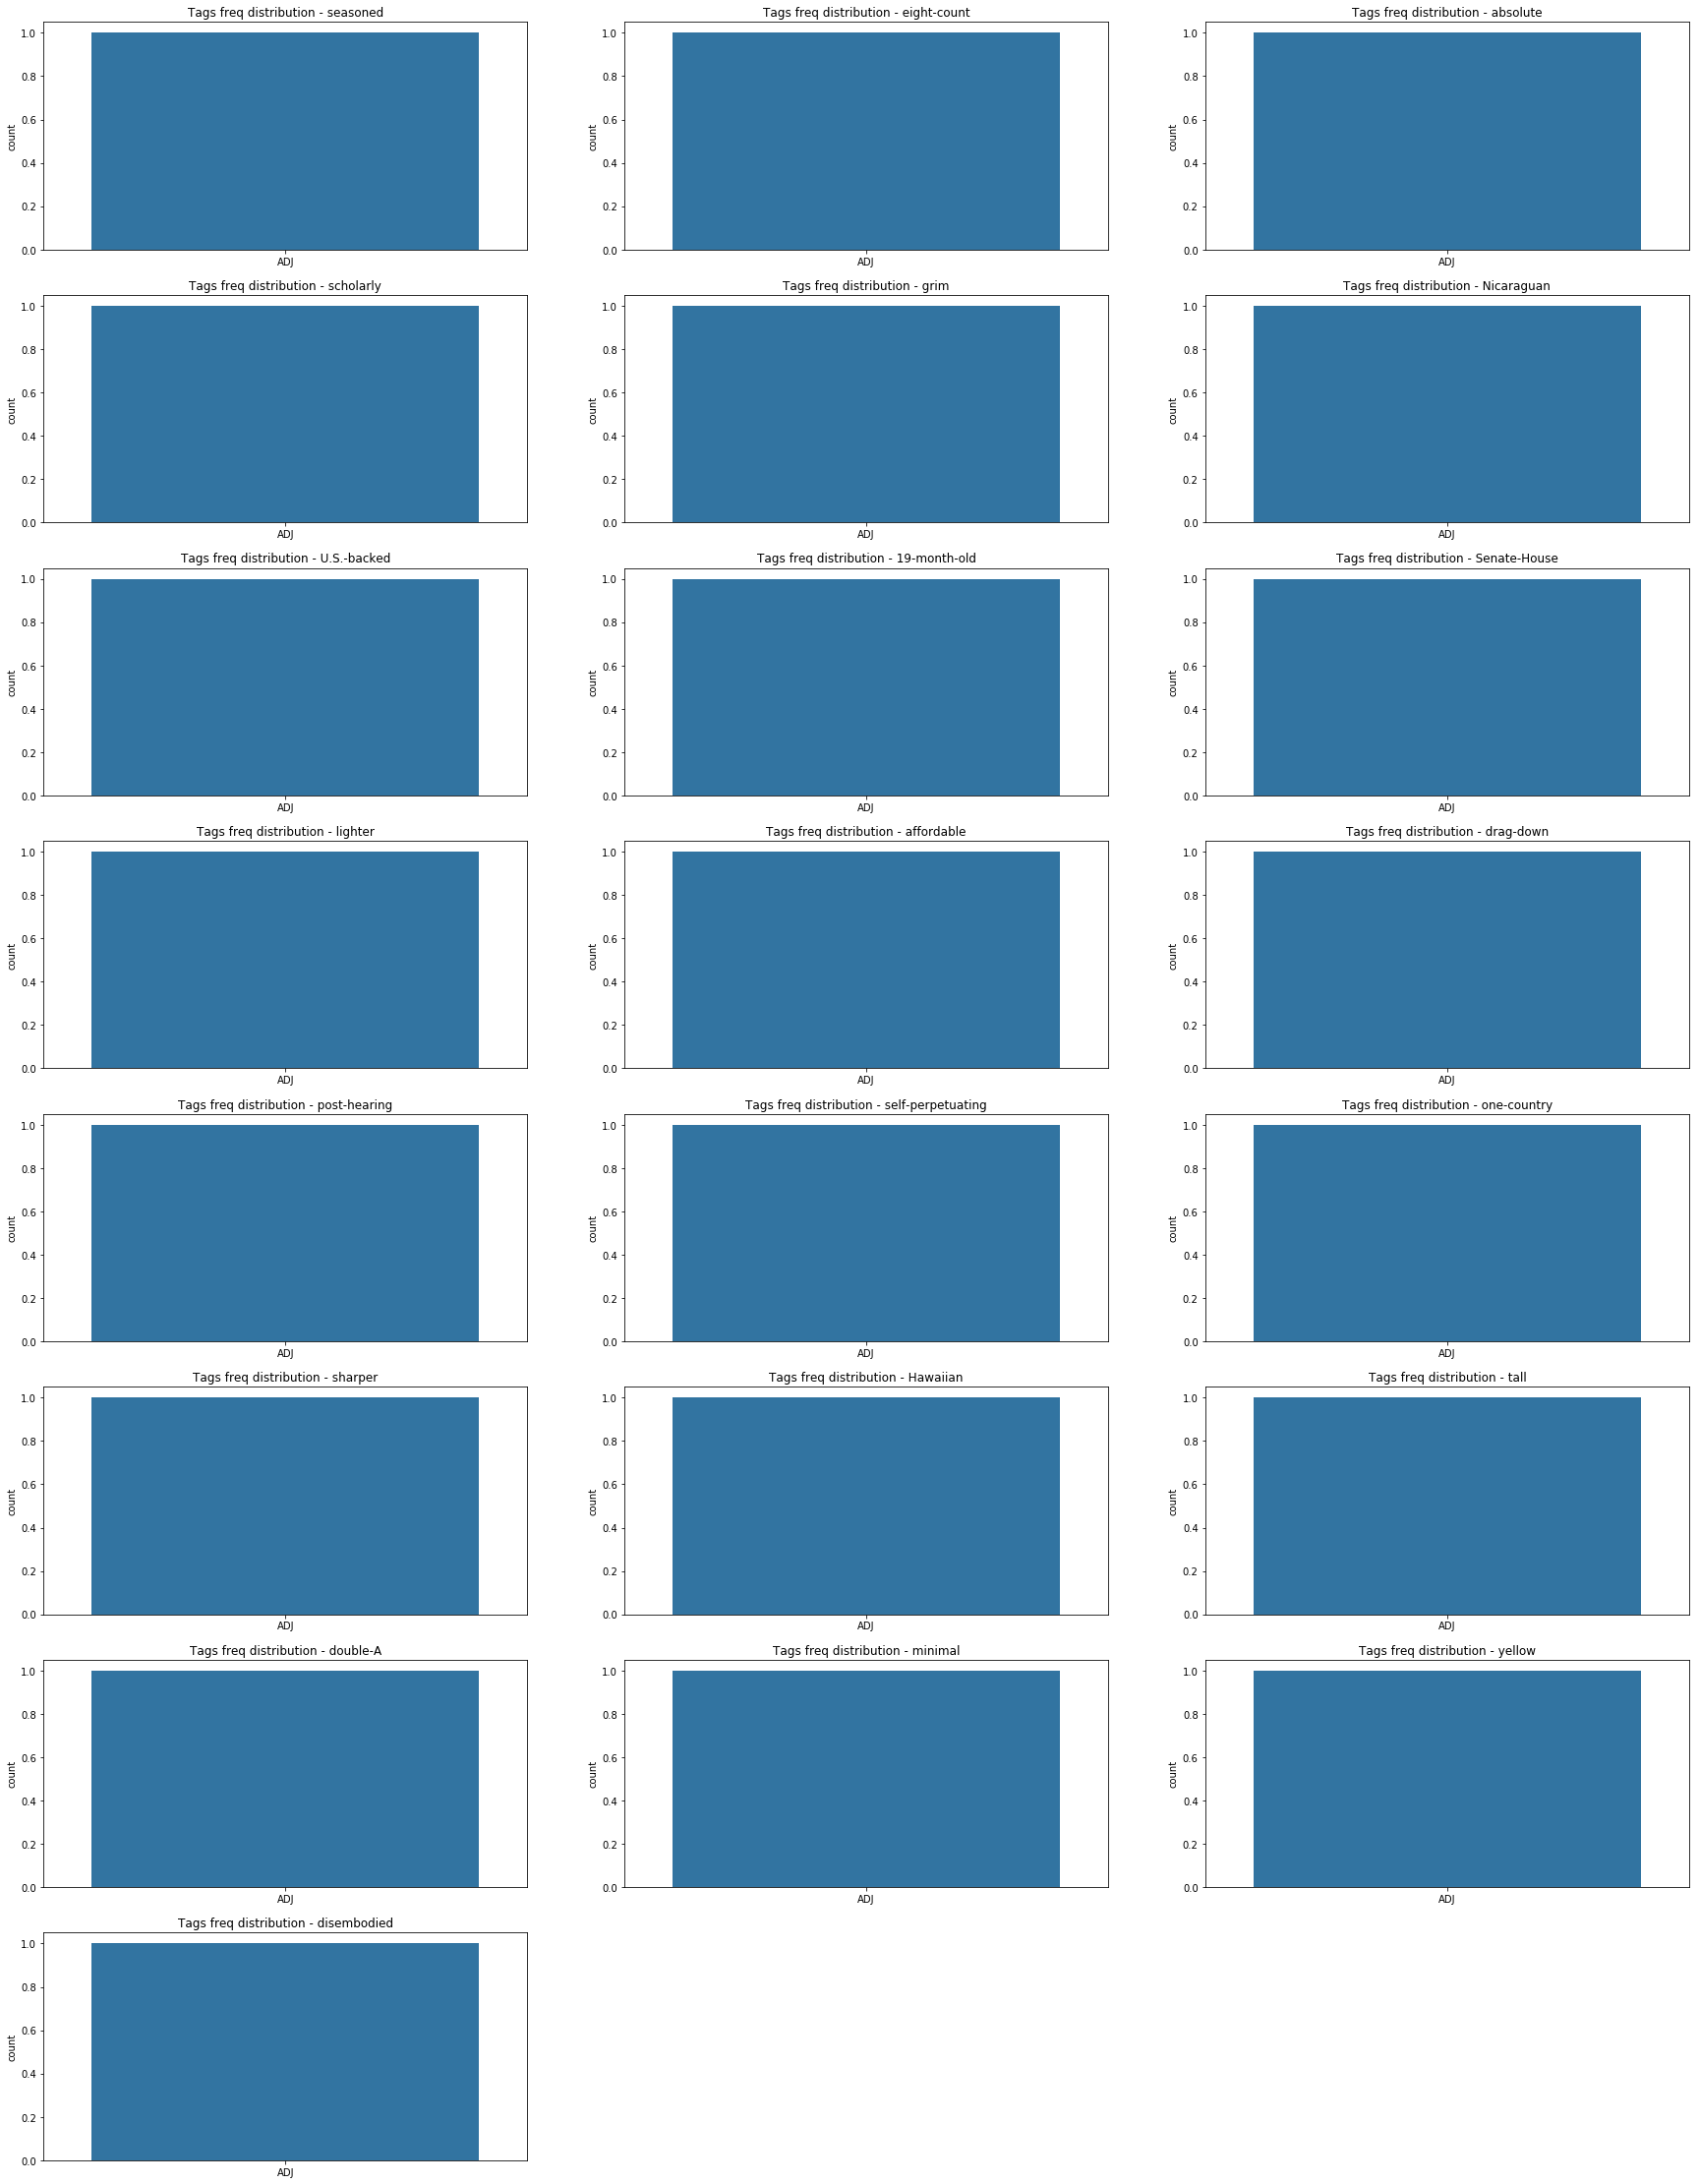

In [36]:
frequency_distribution_for_word_tags(words_for_third_incorrect_tag)

###### Exploring word patterns for any rule-based tagging

<b>First capital letter words pattern</b>

In [37]:
first_capital_letter_distribution = tags_distribution_for_pattern('^[A-Z].+$', default_incorrect_validation_tagged_words)

Total words matching pattern : 96

Most common tags for words matching pattern :
[('NOUN', 82), ('ADJ', 11), ('VERB', 3)]

Tag Ratios : 
Tag , Ratio
NOUN , 85.42 
ADJ , 11.46 
VERB , 3.12 


<b>Words with hyphen pattern</b>

In [38]:
word_with_hyphen_distribution = tags_distribution_for_pattern('^[A-z]+-[A-z]+$', default_incorrect_validation_tagged_words)

Total words matching pattern : 31

Most common tags for words matching pattern :
[('ADJ', 19), ('NOUN', 12)]

Tag Ratios : 
Tag , Ratio
ADJ , 61.29 
NOUN , 38.71 


<b>Based on above evidence, there is no clear pattern emerging for rule-based tagging</b>

##### Exploring 4th pattern 

###### Most Common Words

In [39]:
words_for_fourth_incorrect_tag = get_most_common_words_for_diff_bet_tag(
    default_incorrect_validation_tagged_cases, ('X', 'VERB', '.'))

Most common incorrect tag words:
Previous, Correct, Incorrect:


[(('*T*-1', 'X'), ('feeds', 'VERB'), ('feeds', '.')),
 (('*T*-2', 'X'), ('mandates', 'VERB'), ('mandates', '.')),
 (('*-1', 'X'), ('asserting', 'VERB'), ('asserting', '.')),
 (('*-1', 'X'), ('arrested', 'VERB'), ('arrested', '.')),
 (('*', 'X'), ('Arbitraging', 'VERB'), ('Arbitraging', '.')),
 (('*', 'X'), ('altering', 'VERB'), ('altering', '.')),
 (('*-1', 'X'), ('issuing', 'VERB'), ('issuing', '.')),
 (('*', 'X'), ('disseminating', 'VERB'), ('disseminating', '.')),
 (('*', 'X'), ('reciting', 'VERB'), ('reciting', '.')),
 (('*', 'X'), ('Encouraging', 'VERB'), ('Encouraging', '.')),
 (('*', 'X'), ('PORTING', 'VERB'), ('PORTING', '.')),
 (('*-5', 'X'), ('jumping', 'VERB'), ('jumping', '.'))]

##### Tag frequency distribution for most common words

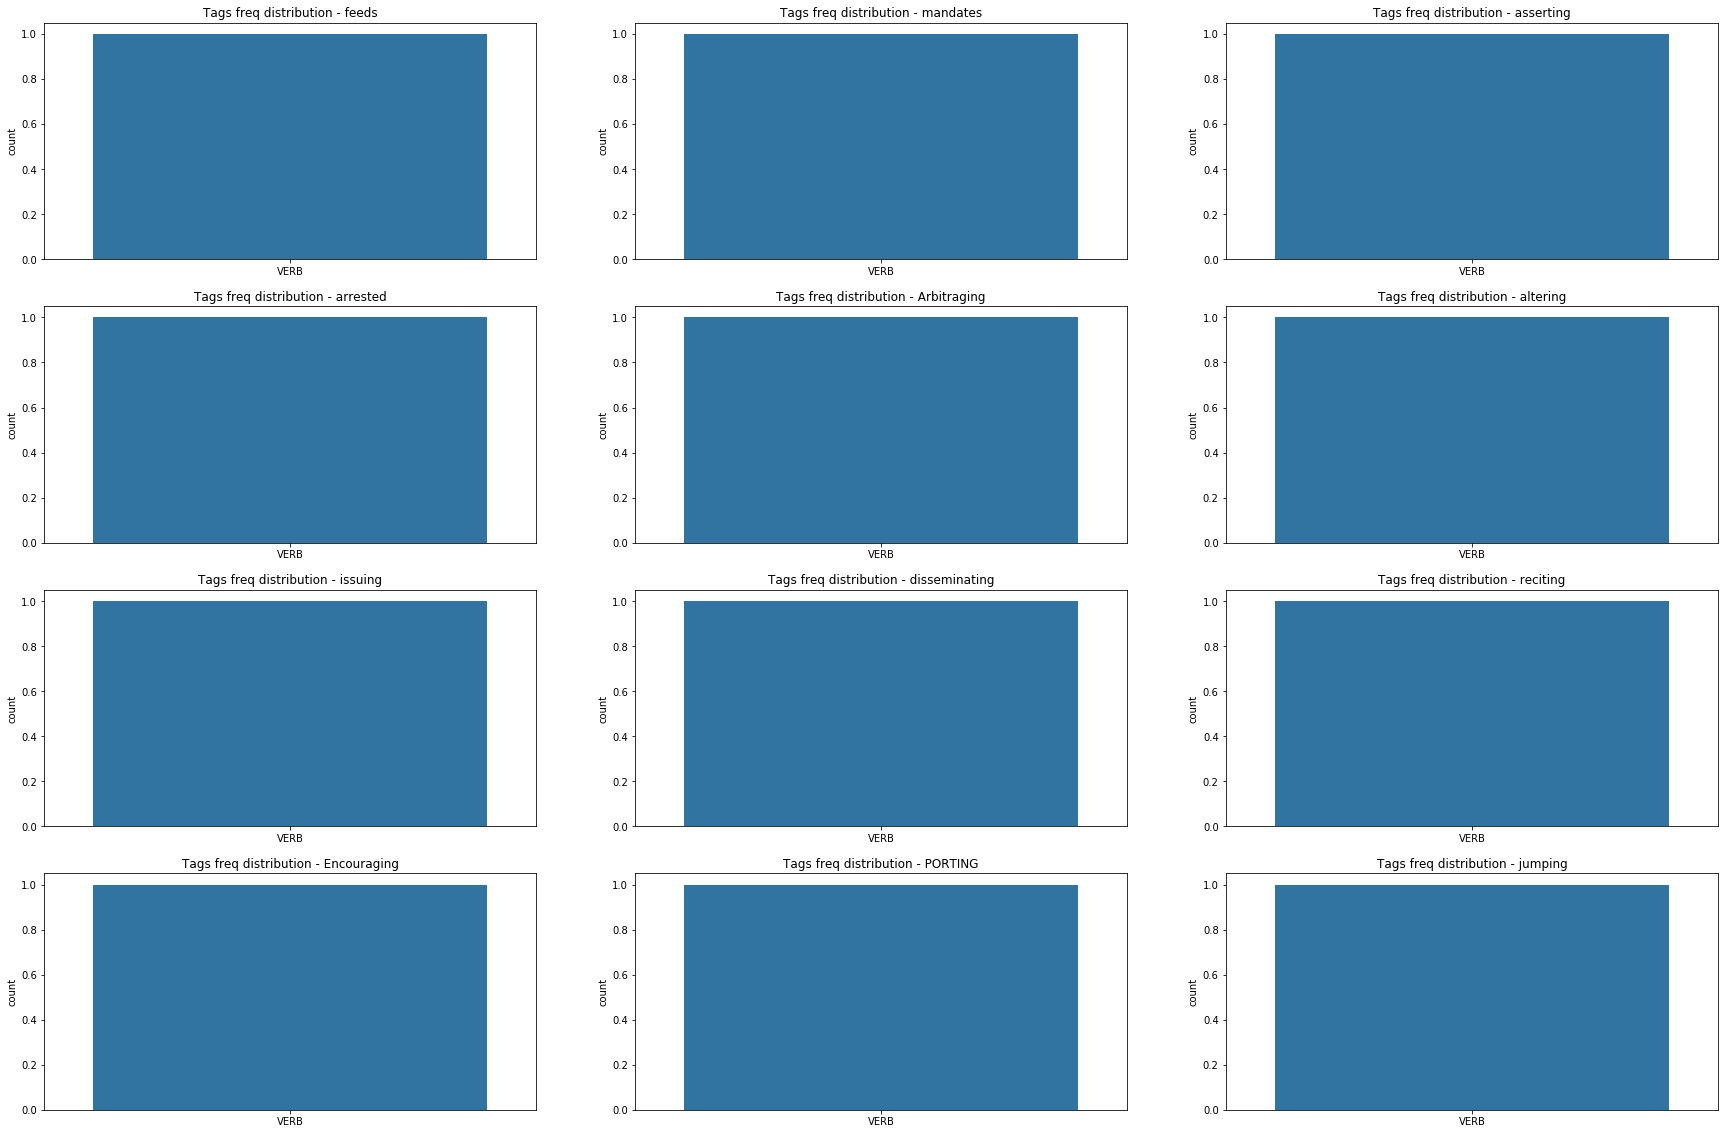

In [40]:
frequency_distribution_for_word_tags(words_for_fourth_incorrect_tag)

###### Exploring word patterns for any rule-based tagging

<b>Words ending with ing, ed, es pattern</b>

In [41]:
words_ending_with_ing_distrib_ed_ed_distribution = tags_distribution_for_pattern('^.*(ing|ed|es)$', 
                                                                                 default_incorrect_validation_tagged_words)

Total words matching pattern : 94

Most common tags for words matching pattern :
[('VERB', 49), ('NOUN', 28), ('ADJ', 17)]

Tag Ratios : 
Tag , Ratio
VERB , 52.13 
NOUN , 29.79 
ADJ , 18.09 


<b>Based on above evidence, there is no clear pattern emerging for rule-based tagging</b>

##### Exploring 5th pattern 

###### Most Common Words

In [42]:
words_for_fifth_incorrect_tag = get_most_common_words_for_diff_bet_tag(
    default_incorrect_validation_tagged_cases, ('.', 'NUM', '.'))

Most common incorrect tag words:
Previous, Correct, Incorrect:


[(('$', '.'), ('38.3', 'NUM'), ('38.3', '.')),
 (('$', '.'), ('12.09', 'NUM'), ('12.09', '.')),
 (('$', '.'), ('62.625', 'NUM'), ('62.625', '.')),
 (('$', '.'), ('1,298', 'NUM'), ('1,298', '.')),
 (('$', '.'), ('13.90', 'NUM'), ('13.90', '.')),
 (('-RRB-', '.'), ('9.75', 'NUM'), ('9.75', '.')),
 ((';', '.'), ('8.70', 'NUM'), ('8.70', '.')),
 ((',', '.'), ('6\\/2', 'NUM'), ('6\\/2', '.')),
 (('$', '.'), ('86.12', 'NUM'), ('86.12', '.')),
 (('$', '.'), ('325,000', 'NUM'), ('325,000', '.')),
 (('$', '.'), ('340,000', 'NUM'), ('340,000', '.')),
 (('$', '.'), ('472', 'NUM'), ('472', '.'))]

##### Tag frequency distribution for most common words

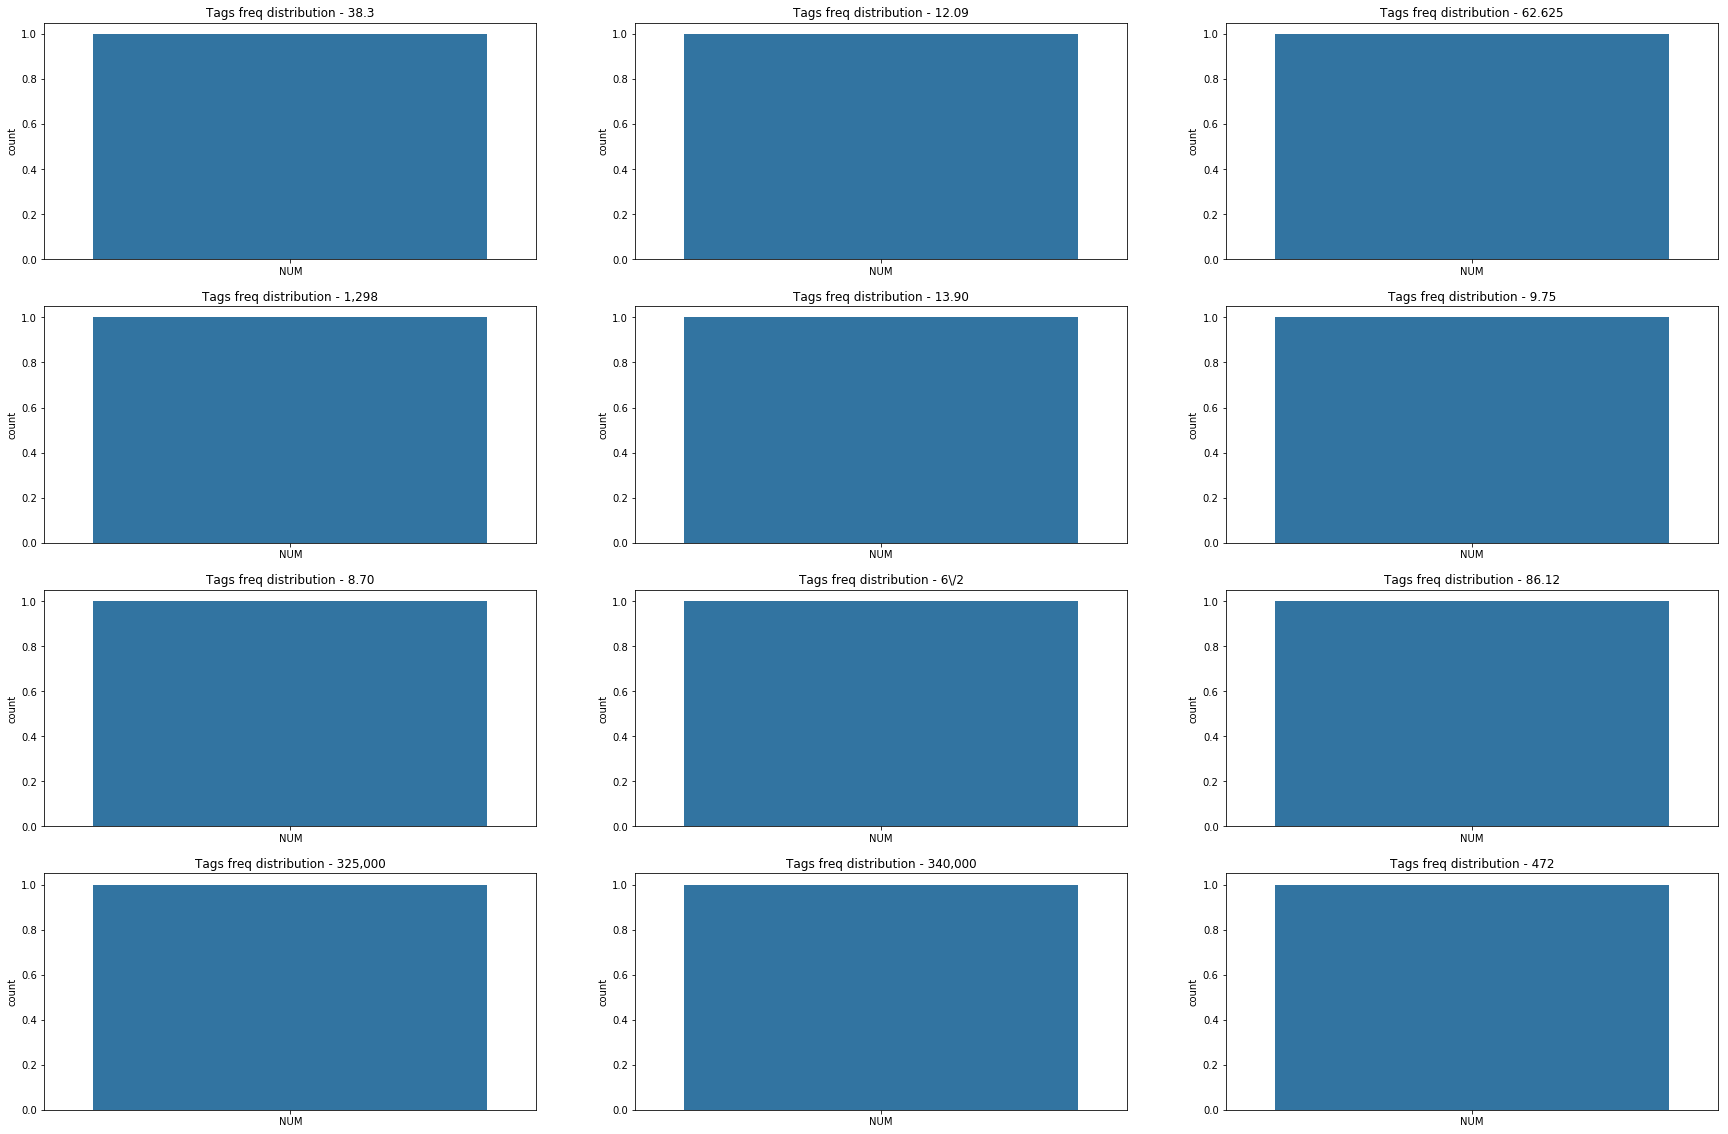

In [43]:
frequency_distribution_for_word_tags(words_for_fifth_incorrect_tag)

###### Exploring word patterns for any rule-based tagging

<b>Words ending with ing, ed, es pattern</b>

In [44]:
num_word_distribution = tags_distribution_for_pattern('^-?[0-9]+(.[0-9]+)?$', default_incorrect_validation_tagged_words)

Total words matching pattern : 27

Most common tags for words matching pattern :
[('NUM', 26), ('X', 1)]

Tag Ratios : 
Tag , Ratio
NUM , 96.3 
X , 3.7 


<b>Based on above evidence, any unknown numeric words should be tagged as 'NUM'</b>

<b> Based on above evidence, 'NOUN' tag is the most common tag in corpus and most of the incorrectly tag unknown words also should be tagged as 'NOUN. Therefore, defaulting all unknown word tags to 'NOUN' incase the same does not fit into any other criteria </b>

#### Implementing 2nd Modified Viterbi

In [45]:
class UpdatedViterbiTagger2(VanillaViterbiTagger):
    
    def __init__(self, train_bag):
        super().__init__(train_bag)
        patterns = [                         
        (r'^-?[0-9]+(.[0-9]+)?$', 'NUM'),
        (r'.*', 'NOUN') 
        ]
        self.regexp_tagger = nltk.RegexpTagger(patterns)
        
    def remove_special_chars(self, word):
        if re.search(r'\d', word):
            return re.sub('[\\\/]+', '', word)
        else:
            return word
    
    def word_to_num(self, word):
        try:
            number = w2n.word_to_num(word)
            output = '{}'.format(number)
        except:
            output = word

        return output

    def tag_words_with_regexp_tagger(self, word_set):
        return self.regexp_tagger.tag(word_set)

    def tag(self, words):
        state = []
        for index, word in enumerate(words):
            p = []
            if word in self.vocab:
                for tag in self.tags:
                    if index == 0:
                        transition_p = self.tags_df.loc['.', tag]
                    else:
                        transition_p = self.tags_df.loc[state[-1], tag]

                    emission_prob = self.get_emission_probability(word, tag)
                    state_prob = emission_prob * transition_p
                    p.append(state_prob)

                pmax = max(p)
                state_max = self.tags[p.index(pmax)]
            else:
                converted_word = self.word_to_num(word)
                converted_word = self.remove_special_chars(converted_word)
                state_max = self.tag_words_with_regexp_tagger([converted_word])[0][1]
                
            state.append(state_max)

        return list(zip(words, state))        

#### Instantiating 2nd Modified Viterbi

In [46]:
updated_viterbi_2 = UpdatedViterbiTagger2(train_tagged_words)

#### Validating 2nd Modified Viterbi implementation

##### Validating word to num method 

In [47]:
print(updated_viterbi_2.word_to_num('FOUR'))
print(updated_viterbi_2.word_to_num('4'))
print(updated_viterbi_2.word_to_num('blah'))

4
4
blah


##### Validating rule-based tagging method

In [48]:
print(updated_viterbi_2.tag_words_with_regexp_tagger(['3.19']))
print(updated_viterbi_2.tag_words_with_regexp_tagger(['clamped']))
print(updated_viterbi_2.tag_words_with_regexp_tagger(['wrestling']))

[('3.19', 'NUM')]
[('clamped', 'NOUN')]
[('wrestling', 'NOUN')]


##### Validating remove special characters method

In [49]:
print(updated_viterbi_2.remove_special_chars('6\\/2'))
print(updated_viterbi_2.remove_special_chars('ICESAT-2'))
print(updated_viterbi_2.remove_special_chars('clamped'))

62
ICESAT-2
clamped


#### POS Tagging Validation Data Set with 2nd Modified Viterbi

In [50]:
updated_predicted_validation_tagged_words_2 = updated_viterbi_2.tag(validation_words)

#### Checking accuracy for validation data set with 2nd Modified Viterbi

In [51]:
check_accuracy(updated_predicted_validation_tagged_words_2, validation_tagged_words)

Accuracy : 0.9444553483807655


#### Most common incorrect tagged cases with 2nd Modified Viterbi

In [52]:
updated_incorrect_validation_tagged_cases_2 = get_diff_bet_tagged_cases(updated_predicted_validation_tagged_words_2, 
                                                            validation_tagged_words)
updated_most_common_validation_incorrect_tags_2 = get_most_common_diff_tags(updated_incorrect_validation_tagged_cases_2)

Total incorrect tag cases : 283
Most common incorrect tagged sequence: 

Previous, Correct, Incorrect:


[(('DET', 'ADJ', 'NOUN'), 20),
 (('NOUN', 'VERB', 'NOUN'), 18),
 (('VERB', 'VERB', 'NOUN'), 15),
 (('X', 'VERB', 'NOUN'), 13),
 (('PRT', 'VERB', 'NOUN'), 13),
 (('NOUN', 'DET', 'ADP'), 13),
 (('VERB', 'ADJ', 'ADV'), 11),
 (('ADP', 'ADJ', 'NOUN'), 11),
 (('DET', 'NOUN', 'ADJ'), 9),
 (('.', 'ADJ', 'NOUN'), 9)]

#### POS Tagging Test Data Set with 2nd Modified Viterbi

In [53]:
updated_predicted_test_tagged_words_2 = updated_viterbi_2.tag(test_words)
print(updated_predicted_test_tagged_words_2)

[('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'NOUN'), ('.', '.'), ('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'NOUN'), ('since', 'ADP'), ('2011', 'NUM'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'NUM'), ('.', '.'), ('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'NUM'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'NOUN'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'NOUN'), ("'s", 'PRT'), ('firehose', 'NOUN'), ('.', '.'), ('Twitter', 'NOUN'), ('is', 'VERB'), ('an', 'DET'), ('online', 'NOUN'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on', 'ADP'), ('which', 'DET'), (

## Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

### Checking accuracy with Vanilla Viterbi

#### For validation data set

In [54]:
check_accuracy(default_predicted_validation_tagged_words, validation_tagged_words)

Accuracy : 0.9089303238469087


#### For test data set

In [55]:
check_accuracy(default_predicted_test_tagged_words, test_tagged_words)

Accuracy : 0.7182320441988951


### Checking accuracy with 1st Modified Viterbi

#### For validation data set

In [56]:
check_accuracy(updated_predicted_validation_tagged_words_1, validation_tagged_words)

Accuracy : 0.9377821393523061


#### For test data set

In [57]:
check_accuracy(updated_predicted_test_tagged_words_1, test_tagged_words)

Accuracy : 0.8121546961325967


### Checking accuracy with 2nd Modified Viterbi

#### For validation data set

In [58]:
check_accuracy(updated_predicted_validation_tagged_words_2, validation_tagged_words)

Accuracy : 0.9444553483807655


#### For test data set

In [59]:
check_accuracy(updated_predicted_test_tagged_words_2, test_tagged_words)

Accuracy : 0.8784530386740331


### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

#### Vanilla Viterbi

##### Most common incorrect test tagged cases

In [60]:
default_incorrect_test_tagged_cases = get_diff_bet_tagged_cases(default_predicted_test_tagged_words, 
                                                            test_tagged_words)

default_most_common_test_incorrect_tags = get_most_common_diff_tags(default_incorrect_test_tagged_cases)

Total incorrect tag cases : 51
Most common incorrect tagged sequence: 

Previous, Correct, Incorrect:


[(('NOUN', 'NOUN', '.'), 7),
 (('ADP', 'NOUN', '.'), 6),
 (('.', 'NOUN', '.'), 5),
 (('ADP', 'NUM', '.'), 3),
 (('NOUN', 'ADP', 'PRT'), 3),
 (('DET', 'ADJ', '.'), 3),
 (('NOUN', 'NOUN', 'PRON'), 3),
 (('ADJ', 'NOUN', '.'), 2),
 (('CONJ', 'VERB', '.'), 2),
 (('NOUN', 'VERB', '.'), 2)]

#### 1st Modified Viterbi Algorithm

##### Most common incorrect test tagged cases

In [61]:
updated_incorrect_test_tagged_cases_1 = get_diff_bet_tagged_cases(updated_predicted_test_tagged_words_1, 
                                                            test_tagged_words)

updated_most_common_test_incorrect_tags_1 = get_most_common_diff_tags(updated_incorrect_test_tagged_cases_1)

Total incorrect tag cases : 34
Most common incorrect tagged sequence: 

Previous, Correct, Incorrect:


[(('ADP', 'NOUN', 'DET'), 5),
 (('ADP', 'NUM', 'DET'), 3),
 (('NOUN', 'ADP', 'PRT'), 3),
 (('DET', 'ADJ', 'NOUN'), 3),
 (('NOUN', 'VERB', 'NOUN'), 3),
 (('NOUN', 'NOUN', 'PRON'), 3),
 (('CONJ', 'VERB', 'NOUN'), 2),
 (('ADJ', 'VERB', 'NOUN'), 1),
 (('NOUN', 'ADV', 'NOUN'), 1),
 (('NUM', 'ADJ', 'ADP'), 1)]

##### Most common different tagged cases with Vanilla Viterbi

In [62]:
difference_with_default_test_tagged_cases_1 = get_diff_bet_tagged_cases(updated_predicted_test_tagged_words_1, 
                                                            default_predicted_test_tagged_words, False)

most_common_difference_with_default_test_tags_1 = get_most_common_diff_tags(
    difference_with_default_test_tagged_cases_1, comparing_incorrect = False)

Total different tag cases : 38
Most common different tagged sequence: 

Previous, Default, Predicted:


[(('.', '.', 'NOUN'), 11),
 (('ADP', '.', 'DET'), 8),
 (('NOUN', '.', 'NOUN'), 6),
 (('DET', '.', 'NOUN'), 4),
 (('CONJ', '.', 'NOUN'), 3),
 (('ADJ', '.', 'NOUN'), 1),
 (('.', 'DET', 'ADP'), 1),
 (('VERB', '.', 'X'), 1),
 (('PRT', '.', 'VERB'), 1),
 (('.', 'VERB', 'PRT'), 1)]

##### Comparison of updated POS tag vs Vanilla Viterbi

In [63]:
find_metrics_for_updated_viterbi(updated_incorrect_test_tagged_cases_1, difference_with_default_test_tagged_cases_1)  

Total updated correct tag cases : 17
Previous, Default, Correct


[(('.', '.'), ('Android', '.'), ('Android', 'NOUN')),
 (('.', '.'), ('Android', '.'), ('Android', 'NOUN')),
 (('best-selling', 'ADJ'), ('OS', '.'), ('OS', 'NOUN')),
 (('.', '.'), ('Google', '.'), ('Google', 'NOUN')),
 (('and', 'CONJ'), ('Twitter', '.'), ('Twitter', 'NOUN')),
 (('Twitter', '.'), ("'s", 'VERB'), ("'s", 'PRT')),
 (('.', '.'), ('Twitter', '.'), ('Twitter', 'NOUN')),
 (('television', 'NOUN'), ('personality', '.'), ('personality', 'NOUN')),
 (('2018', '.'), ('FIFA', '.'), ('FIFA', 'NOUN')),
 (('World', 'NOUN'), ('Cup', '.'), ('Cup', 'NOUN')),
 (('21st', '.'), ('FIFA', '.'), ('FIFA', 'NOUN')),
 (('World', 'NOUN'), ('Cup', '.'), ('Cup', 'NOUN')),
 (('football', 'NOUN'), ('tournament', '.'), ('tournament', 'NOUN')),
 (('World', 'NOUN'), ('Cup', '.'), ('Cup', 'NOUN')),
 (('round', 'NOUN'), ('trips', '.'), ('trips', 'NOUN')),
 (('.', '.'), ('NASA', '.'), ('NASA', 'NOUN')),
 (('ICESAT-2', '.'), ('Satellite', '.'), ('Satellite', 'NOUN'))]

Total updated incorrect tag cases : 21
Previous, Default, Incorrect


[(('by', 'ADP'), ('Google', '.'), ('Google', 'DET')),
 (('OS', '.'), ('worldwide', '.'), ('worldwide', 'NOUN')),
 (('on', 'ADP'), ('smartphones', '.'), ('smartphones', 'DET')),
 (('since', 'ADP'), ('2011', '.'), ('2011', 'DET')),
 (('since', 'ADP'), ('2013', '.'), ('2013', 'DET')),
 (('in', 'ADP'), ('2015', '.'), ('2015', 'DET')),
 (('2015', '.'), ('that', 'DET'), ('that', 'ADP')),
 (('gave', 'VERB'), ('Google', '.'), ('Google', 'X')),
 (('to', 'PRT'), ('Twitter', '.'), ('Twitter', 'VERB')),
 (("'s", 'VERB'), ('firehose', '.'), ('firehose', 'VERB')),
 (('an', 'DET'), ('online', '.'), ('online', 'NOUN')),
 (('and', 'CONJ'), ('interact', '.'), ('interact', 'NOUN')),
 (('with', 'ADP'), ('messages', '.'), ('messages', 'DET')),
 (('as', 'ADP'), ('tweets', '.'), ('tweets', 'DET')),
 (('a', 'DET'), ('domineering', '.'), ('domineering', 'NOUN')),
 (('The', 'DET'), ('2018', '.'), ('2018', 'NOUN')),
 (('the', 'DET'), ('21st', '.'), ('21st', 'NOUN')),
 (('tournament', '.'), ('contested', '.'), ('

#### 2nd Modified Viterbi Algorithm

##### Most common incorrect test tagged cases

In [64]:
updated_incorrect_test_tagged_cases_2 = get_diff_bet_tagged_cases(updated_predicted_test_tagged_words_2, 
                                                            test_tagged_words)

updated_most_common_test_incorrect_tags_2 = get_most_common_diff_tags(updated_incorrect_test_tagged_cases_2)

Total incorrect tag cases : 22
Most common incorrect tagged sequence: 

Previous, Correct, Incorrect:


[(('NOUN', 'ADP', 'PRT'), 3),
 (('DET', 'ADJ', 'NOUN'), 3),
 (('NOUN', 'VERB', 'NOUN'), 3),
 (('NOUN', 'NOUN', 'PRON'), 3),
 (('CONJ', 'VERB', 'NOUN'), 2),
 (('ADJ', 'VERB', 'NOUN'), 1),
 (('NOUN', 'ADV', 'NOUN'), 1),
 (('NUM', 'ADJ', 'ADP'), 1),
 (('ADP', 'ADJ', 'DET'), 1),
 (('NOUN', 'ADJ', 'ADP'), 1)]

##### Most common different tagged cases with Vanilla Viterbi

In [65]:
difference_with_default_test_tagged_cases_2 = get_diff_bet_tagged_cases(updated_predicted_test_tagged_words_2, 
                                                            default_predicted_test_tagged_words, False)

most_common_difference_with_default_test_tags_2 = get_most_common_diff_tags(
    difference_with_default_test_tagged_cases_2, comparing_incorrect = False)

Total different tag cases : 38
Most common different tagged sequence: 

Previous, Default, Predicted:


[(('.', '.', 'NOUN'), 11),
 (('NOUN', '.', 'NOUN'), 6),
 (('ADP', '.', 'NOUN'), 5),
 (('ADP', '.', 'NUM'), 3),
 (('CONJ', '.', 'NOUN'), 3),
 (('DET', '.', 'NOUN'), 3),
 (('VERB', '.', 'NOUN'), 2),
 (('ADJ', '.', 'NOUN'), 1),
 (('.', 'DET', 'ADP'), 1),
 (('PRT', '.', 'NOUN'), 1)]

##### Comparison of updated POS tag vs Vanilla Viterbi

In [66]:
find_metrics_for_updated_viterbi(updated_incorrect_test_tagged_cases_2, difference_with_default_test_tagged_cases_2)  

Total updated correct tag cases : 29
Previous, Default, Correct


[(('.', '.'), ('Android', '.'), ('Android', 'NOUN')),
 (('by', 'ADP'), ('Google', '.'), ('Google', 'NOUN')),
 (('.', '.'), ('Android', '.'), ('Android', 'NOUN')),
 (('best-selling', 'ADJ'), ('OS', '.'), ('OS', 'NOUN')),
 (('on', 'ADP'), ('smartphones', '.'), ('smartphones', 'NOUN')),
 (('since', 'ADP'), ('2011', '.'), ('2011', 'NUM')),
 (('since', 'ADP'), ('2013', '.'), ('2013', 'NUM')),
 (('.', '.'), ('Google', '.'), ('Google', 'NOUN')),
 (('and', 'CONJ'), ('Twitter', '.'), ('Twitter', 'NOUN')),
 (('in', 'ADP'), ('2015', '.'), ('2015', 'NUM')),
 (('gave', 'VERB'), ('Google', '.'), ('Google', 'NOUN')),
 (('to', 'PRT'), ('Twitter', '.'), ('Twitter', 'NOUN')),
 (('Twitter', '.'), ("'s", 'VERB'), ("'s", 'PRT')),
 (("'s", 'VERB'), ('firehose', '.'), ('firehose', 'NOUN')),
 (('.', '.'), ('Twitter', '.'), ('Twitter', 'NOUN')),
 (('with', 'ADP'), ('messages', '.'), ('messages', 'NOUN')),
 (('as', 'ADP'), ('tweets', '.'), ('tweets', 'NOUN')),
 (('television', 'NOUN'), ('personality', '.'), ('p

Total updated incorrect tag cases : 9
Previous, Default, Incorrect


[(('OS', '.'), ('worldwide', '.'), ('worldwide', 'NOUN')),
 (('2015', '.'), ('that', 'DET'), ('that', 'ADP')),
 (('an', 'DET'), ('online', '.'), ('online', 'NOUN')),
 (('and', 'CONJ'), ('interact', '.'), ('interact', 'NOUN')),
 (('a', 'DET'), ('domineering', '.'), ('domineering', 'NOUN')),
 (('the', 'DET'), ('21st', '.'), ('21st', 'NOUN')),
 (('tournament', '.'), ('contested', '.'), ('contested', 'NOUN')),
 (('and', 'CONJ'), ('arriving', '.'), ('arriving', 'NOUN')),
 (('NASA', '.'), ('invited', '.'), ('invited', 'NOUN'))]